In [5]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


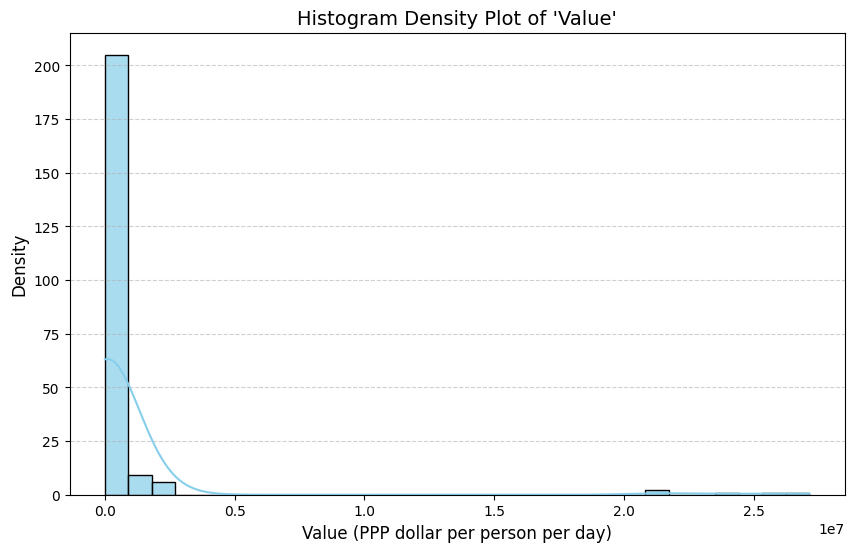

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/content/FAOSTAT_data_en_12-8-2024_sak.csv'
data = pd.read_csv(file_path)

# Cleaning the data: Dropping rows with missing values in the "Value" column
cleaned_data = data.dropna(subset=["Value"])

# Plotting the histogram density plot for the "Value" column
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data["Value"], kde=True, bins=30, color='skyblue', alpha=0.7)
plt.title("Histogram Density Plot of 'Value'", fontsize=14)
plt.xlabel("Value (PPP dollar per person per day)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


/tmp/ipython-input-39-3354144607.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




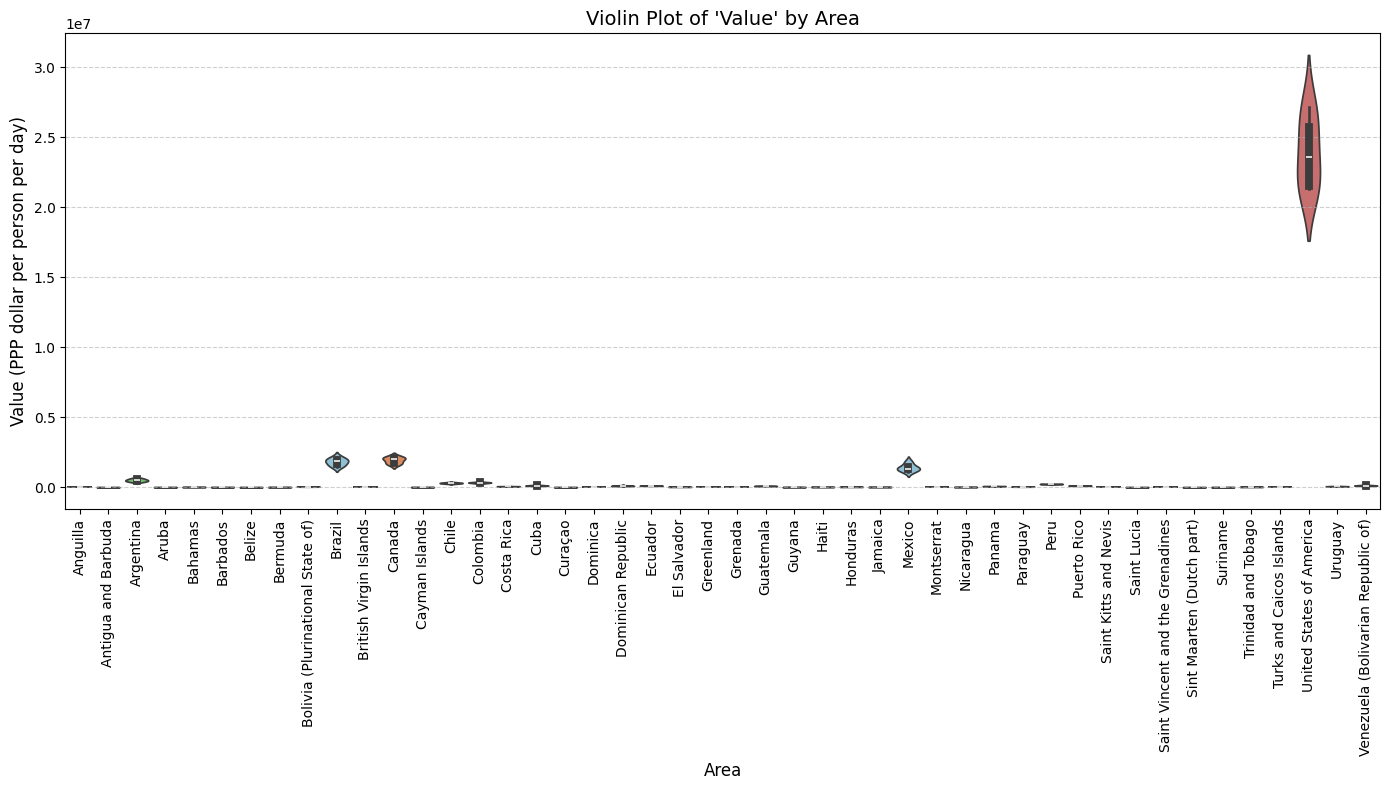

In [39]:
# Violin plot for "Value" grouped by "Area"
plt.figure(figsize=(14, 8))
sns.violinplot(data=cleaned_data, x="Area", y="Value", palette="muted")
plt.xticks(rotation=90, fontsize=10)  # Rotate x-axis labels for better readability
plt.title("Violin Plot of 'Value' by Area", fontsize=14)
plt.xlabel("Area", fontsize=12)
plt.ylabel("Value (PPP dollar per person per day)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Cleaning and preparing the data
grouped_data = cleaned_data.groupby(["Year", "Area"])["Value"].mean().reset_index()

# Setting up the figure
fig, ax = plt.subplots(figsize=(12, 8))

# Animation function
def update(year):
    ax.clear()
    year_data = grouped_data[grouped_data["Year"] == year].sort_values(by="Value", ascending=False).head(10)
    ax.barh(year_data["Area"], year_data["Value"], color='skyblue')
    ax.set_title(f"Top 10 Areas by Value in {year}", fontsize=16)
    ax.set_xlabel("Value (PPP dollar per person per day)", fontsize=12)
    ax.set_xlim(0, grouped_data["Value"].max() * 1.1)
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    ax.tick_params(axis='y', labelsize=10)

# Years to animate
years = sorted(cleaned_data["Year"].unique())

# Creating the animation
ani = FuncAnimation(fig, update, frames=years, repeat=False)

# Save or display animation
plt.close()
ani.save("animated_bar_plot.gif", writer="imagemagick", fps=1)


/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning:

Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.



In [31]:
import pandas as pd
import plotly.express as px

# Load the dataset (update the file path if needed)
file_path = '/content/FAOSTAT_data_en_12-8-2024_sak.csv'
data = pd.read_csv(file_path)

# Clean the data
cleaned_data = data.drop(columns=['Note'])  # Drop the 'Note' column
cleaned_data.columns = [col.replace(" ", "_").lower() for col in cleaned_data.columns]  # Simplify column names

# Filter data for Gross Domestic Product
gdp_data = cleaned_data[cleaned_data['item'] == 'Gross Domestic Product']

# Create an interactive visualization
fig = px.line(
    gdp_data,
    x='year',
    y='value',
    color='area',
    title='GDP Trends by Year and Area',
    labels={'value': 'GDP (million USD)', 'year': 'Year', 'area': 'Area'},
    markers=True
)

fig.update_layout(legend_title_text='Area', hovermode='x unified')

# Display the plot
fig.show()


In [33]:
from dash import Dash, dcc, html, Input, Output
import pandas as pd
import plotly.express as px

# Load and clean the dataset
file_path = '/content/FAOSTAT_data_en_12-8-2024_sak.csv'
data = pd.read_csv(file_path)

# Ensure 'Value' column is numeric
data['Value'] = pd.to_numeric(data['Value'], errors='coerce')
cleaned_data = data.dropna(subset=["Value"])

# Aggregate the data
aggregated_data = cleaned_data.groupby(["Area", "Year"]).agg({"Value": "mean"}).reset_index()

# Initialize Dash app
app = Dash(__name__)

# App layout
app.layout = html.Div([
    html.H1("Interactive Tabular Data and Bar Plot", style={"textAlign": "center"}),

    # Dropdown to select Area
    html.Div([
        html.Label("Select Area:"),
        dcc.Dropdown(
            id="area-dropdown",
            options=[{"label": area, "value": area} for area in cleaned_data["Area"].unique()],
            multi=True,
            placeholder="Select one or more areas"
        )
    ], style={"width": "40%", "display": "inline-block", "padding": "10px"}),

    # Slider to select Year range
    html.Div([
        html.Label("Select Year Range:"),
        dcc.RangeSlider(
            id="year-slider",
            min=int(cleaned_data["Year"].min()),
            max=int(cleaned_data["Year"].max()),
            marks={int(year): str(year) for year in cleaned_data["Year"].unique()},
            value=[int(cleaned_data["Year"].min()), int(cleaned_data["Year"].max())]
        )
    ], style={"width": "90%", "padding": "10px"}),

    # Bar plot visualization
    html.Div([
        dcc.Graph(id="bar-plot")
    ]),

    # Table visualization
    html.Div(id="table-container", style={"padding": "20px"})
])

# Callback to update bar plot and table based on user input
@app.callback(
    [Output("bar-plot", "figure"),
     Output("table-container", "children")],
    [Input("area-dropdown", "value"),
     Input("year-slider", "value")]
)
def update_visualizations(selected_areas, year_range):
    # Filter data based on input values
    filtered_data = aggregated_data[
        (aggregated_data["Year"] >= year_range[0]) &
        (aggregated_data["Year"] <= year_range[1])
    ]
    if selected_areas:
        filtered_data = filtered_data[filtered_data["Area"].isin(selected_areas)]

    # Create bar plot visualization
    bar_plot = px.bar(
        filtered_data,
        x="Year",
        y="Value",
        color="Area",
        barmode="group",
        title="Bar Plot of Values by Year and Area",
        labels={"Value": "Average Value", "Year": "Year"}
    )

    # Create table visualization
    table = html.Table(
        # Header
        [html.Tr([html.Th(col) for col in filtered_data.columns])] +
        # Body
        [html.Tr([html.Td(filtered_data.iloc[i][col]) for col in filtered_data.columns])
         for i in range(len(filtered_data))]
    )

    return bar_plot, table

# Run the app
if __name__ == "__main__":
    app.run(debug=True)


<IPython.core.display.Javascript object>

In [36]:
# Import necessary libraries
import pandas as pd
import plotly.express as px

# Load your dataset (replace 'your_file.csv' with the actual filename)
file_path = '/content/FAOSTAT_data_en_12-8-2024_sak.csv'  # Update this to your file's location
data = pd.read_csv(file_path)

# Rename columns for clarity
cleaned_data = data.rename(columns={"Area": "Country", "Value": "Metric Value"})

# Create the interactive choropleth map with a diverging color scale
fig = px.choropleth(
    cleaned_data,
    locations="Country",
    locationmode="country names",
    color="Metric Value",
    hover_name="Country",
    animation_frame="Year",
    title="Interactive Map Visualization Over Time",
    color_continuous_scale=px.colors.diverging.Spectral,  # Change color scale for more contrast
    labels={"Metric Value": "Value", "Year": "Year"}
)

# Update layout for better readability
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True, projection_type='natural earth'),
    coloraxis_colorbar=dict(title="Metric Value")
)

# Show the interactive map
fig.show()
